<!-- version
- v1: two Conv2D
- v2: one Conv2D (the same config as models in splice and promoters)
- v3: one Conv2D (the same config as the model in the original paper)
- v4: two Conv2D (the same config as the model in histone paper)
- v5: three Conv2D with BatchNorm
- v6: four Conv2D with BatchNorm -->

version
- v1: two Conv2d
- v2: three Conv2d
- v3: four Conv2d
- v4: four Conv2d with l2

# Setup

In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 4.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/My Drive/data/ChIP-seq/'

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py


In [4]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from dna_nn.load import encode, encoded_shape, gen_from_fasta

%load_ext autoreload
%autoreload 2

## Inspect the files included in the dataset

In [ ]:
import re

base_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/{}'
!curl {base_url.format('files.txt')} -so files.txt

In [ ]:
with open('files.txt', 'r') as f:
    with open('output.txt', 'w') as out:
        for line in f:
            out.write(re.sub('control=.+?; ', '', line))

files = pd.read_csv('output.txt', header=None, index_col=0, sep=';?\\s+', engine='python')
files.drop(columns=[10, 11, 12], inplace=True)
files.index.name ='file'
files.columns = files.iloc[0].str.split('=', expand=True)[0]
files = files.apply(lambda ser: ser.str.split('=', expand=True)[1]
                    if ser.str.count('=').all() else ser)
files.reset_index(inplace=True)
files.to_csv('output.csv', index=False)
files['file'] = files['file'].str.replace('.narrowPeak.gz', '')
files.head()

,file,project,lab,composite,dataType,view,cell,treatment,antibody,dataVersion,dccAccession,controlId,quality,tableName,type,md5sum,size
0,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,Dnd41,None,CTCF,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,d24dcb...,966K
1,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,Dnd41,None,EZH2_(...,ENCODE,wgEnco...,wgEnco...,caution,wgEnco...,narrow...,effd48...,43K
2,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,GM12878,None,CTCF,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,fef0af...,982K
3,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,GM12878,None,EZH2_(...,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,9a8766...,66K
4,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,H1-hESC,None,CHD1_(...,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,71891a...,184K


# Download data

In [ ]:
# 5~9 minutes each depending on the network
chip_seq('motif_discovery')
chip_seq('motif_occupancy')

# Transform data into fasta format

In [ ]:
def summary(df):
    '''
    plot stats for the class distribution

    the top figure shows the number of files with certain number of sequences
    the bottom figure shows the class distribution if we take certain number of
    sequences from each file (a file doesn't contribute any more after all its
    sequences are taken)
    '''
    stats = df.groupby(by=df.index)[2].agg(['count', 'sum'])
    cumsum = stats.cumsum()
    ratio = cumsum['sum'] / cumsum['count']

    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
    stats['count'].plot(ax=ax0)
    ratio.plot(ax=ax1)

    ax0.set_xlabel('# sequences')
    ax0.set_ylabel('# files')
    ax1.set_xlabel('# sequences taken from each file')
    ax1.set_ylabel('% of positive samples')

    ax0.grid();ax1.grid()

## Motif discovery training set

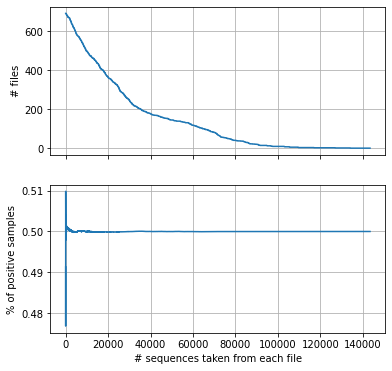

In [ ]:
motif_discovery_train = load_chip_seq_as_df('motif_discovery', 'train.data')
summary(motif_discovery_train)

In [ ]:
# 20464149it [49:16, 6922.75it/s]
df_to_fasta(motif_discovery_train, 'motif_discovery_train.fasta')

In [ ]:
del motif_discovery_train
gc.collect()

4

## Motit occupancy training set

Skip wgEncodeAwgTfbsHaibEcc1GrV0416102Dex100nmUniPk



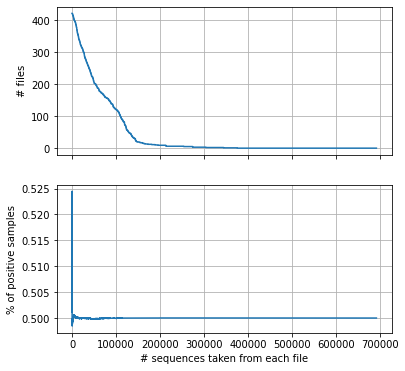

In [ ]:
# motif_occupancy/wgEncodeAwgTfbsHaibEcc1GrV0416102Dex100nmUniPk/train.data is corrupted
motif_occupancy_train = load_chip_seq_as_df('motif_occupancy', 'train.data')
summary(motif_occupancy_train)

In [ ]:
# 28694274it [1:10:03, 6826.32it/s]
df_to_fasta(motif_occupancy_train, 'motif_occupancy_train.fasta')

In [ ]:
del motif_occupancy_train
gc.collect()

4969

## Test set

In [ ]:
# test data

# 5116385it [12:25, 6860.87it/s]
motif_discovery_test = load_chip_seq_as_df('motif_discovery', 'test.data')
df_to_fasta(motif_discovery_test, 'motif_discovery_test.fasta')
del motif_discovery_test
gc.collect()

# 7178864it [17:34, 6826.32it/s]
motif_occupancy_test = load_chip_seq_as_df('motif_occupancy', 'test.data')
df_to_fasta(motif_occupancy_test, 'motif_occupancy_test.fasta')
del motif_occupancy_test
gc.collect()

8

# Motif Discovery

## Create dataset

In [5]:
# generators
word_size = 3
region_size = 2
subset_size = 690 * 190

x_shape = encoded_shape(range(101), word_size, region_size)
encode_func = encode(word_size, region_size)

train_file = DATA_DIR + 'motif_discovery_train.fasta'
test_file = DATA_DIR + 'motif_discovery_test.fasta'
train_gen = gen_from_fasta(train_file, encode_func)
test_gen = gen_from_fasta(test_file, encode_func)

# datasets
bacth_size = 512
prefetch = tf.data.experimental.AUTOTUNE

output_shapes = (x_shape, ())
output_types = (tf.float32, tf.float32)

train_ds = Dataset.from_generator(train_gen, output_types, output_shapes)
# takes about 30 seconds to skip the training data
val_ds = train_ds.skip(subset_size).take(690 * 10)
train_ds = train_ds.take(subset_size).shuffle(500).batch(bacth_size).prefetch(prefetch)

test_ds = Dataset.from_generator(test_gen, output_types, output_shapes)
test_ds = test_ds.take(subset_size).batch(bacth_size).prefetch(prefetch)

print('x shape:', train_ds.element_spec[0].shape)
print('y shape:', train_ds.element_spec[1].shape)

x shape: (None, 99, 192, 1)
y shape: (None,)


In [6]:
%%time
x_val, y_val = [], []
for d in val_ds:
    x_val.append(d[0])
    y_val.append(d[1])
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
validation_data = (x_val, y_val)

CPU times: user 1min 1s, sys: 4.22 s, total: 1min 6s
Wall time: 1min 2s


## Build model

In [11]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(16, 3, activation='relu', input_shape=x_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer='l2'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer='l2'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer='l2'),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 190, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 97, 190, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 95, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 93, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 93, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 44, 64)        1

In [12]:
version = 'v4'
LOG_DIR = '/content/drive/My Drive/dna-nn/motif-discovery/'

callbacks = [
    keras.callbacks.CSVLogger(LOG_DIR + f'{version}.csv'),
    keras.callbacks.TensorBoard(log_dir=LOG_DIR + f'log/{version}/'),
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: gc.collect(),
        on_train_end=lambda logs: model.save(LOG_DIR + f'{version}.h5')
    ),
]

# 33ms/step
# 319752steps
# 20464149 / 64 * 33 / 1000 / 3600 = 2.9 hours for one epoch
history = model.fit(train_ds, validation_data=validation_data, epochs=30, callbacks=callbacks)

Epoch 1/30
      2/Unknown - 0s 198ms/step - loss: 3.5893 - accuracy: 0.5146WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1093s vs `on_train_batch_end` time: 0.2823s). Check your callbacks.
257/257 [==============================] - 70s 271ms/step - loss: 1.5763 - accuracy: 0.5098 - val_loss: 1.0386 - val_accuracy: 0.5059
Epoch 2/30
257/257 [==============================] - 70s 271ms/step - loss: 0.8574 - accuracy: 0.5342 - val_loss: 0.9106 - val_accuracy: 0.5059
Epoch 3/30
257/257 [==============================] - 70s 272ms/step - loss: 0.7324 - accuracy: 0.5623 - val_loss: 0.7425 - val_accuracy: 0.4952
Epoch 4/30
257/257 [==============================] - 70s 271ms/step - loss: 0.7070 - accuracy: 0.5837 - val_loss: 0.9604 - val_accuracy: 0.4941
Epoch 5/30
257/257 [==============================] - 69s 270ms/step - loss: 0.7077 - accuracy: 0.5909 - val_loss: 0.8620 - val_accuracy: 0.4942
Epoch 6/30
257/257 [===============

In [9]:
model.evaluate(test_ds)

257/257 [==============================] - 63s 244ms/step - loss: 1.4425 - accuracy: 0.5978


[1.4424998760223389, 0.5978260636329651]

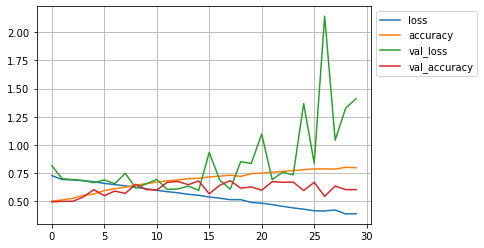

In [10]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()